# DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 

Version 3.24

[Andreas Loukas](https://andreasloukas.wordpress.com/), [EPFL LTS2](https://lts2.epfl.ch/), [Michaël Defferrard](http://deff.ch)

Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3. 

The five core features are:

* PRCP = Precipitation (tenths of mm)
* SNOW = Snowfall (mm)
* SNWD = Snow depth (mm)
* TMAX = Maximum temperature (tenths of degrees C)
* TMIN = Minimum temperature (tenths of degrees C)

The other features are:

* ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
* ACMH = Average cloudiness midnight to midnight from manual observations (percent)
* ACSC = Average cloudiness sunrise to sunset from 30-second ceilometer data (percent)
* ACSH = Average cloudiness sunrise to sunset from manual observations (percent)
* AWDR = Average daily wind direction (degrees)
* AWND = Average daily wind speed (tenths of meters per second)
* DAEV = Number of days included in the multiday evaporation total (MDEV)
* DAPR = Number of days included in the multiday precipiation total (MDPR)
* DASF = Number of days included in the multiday snowfall total (MDSF)		  
* DATN = Number of days included in the multiday minimum temperature (MDTN)
* DATX = Number of days included in the multiday maximum temperature (MDTX)
* DAWM = Number of days included in the multiday wind movement (MDWM)
* DWPR = Number of days with non-zero precipitation included in multiday precipitation total (MDPR)
* EVAP = Evaporation of water from evaporation pan (tenths of mm)
* FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
* FRGB = Base of frozen ground layer (cm)
* FRGT = Top of frozen ground layer (cm)
* FRTH = Thickness of frozen ground layer (cm)
* GAHT = Difference between river and gauge height (cm)
* MDEV = Multiday evaporation total (tenths of mm; use with DAEV)
* MDPR = Multiday precipitation total (tenths of mm; use with DAPR and DWPR, if available)
* MDSF = Multiday snowfall total 
* MDTN = Multiday minimum temperature (tenths of degrees C; use with DATN)
* MDTX = Multiday maximum temperature (tenths of degress C; use with DATX)
* MDWM = Multiday wind movement (km)
* MNPN = Daily minimum temperature of water in an evaporation pan (tenths of degrees C)
* MXPN = Daily maximum temperature of water in an evaporation pan (tenths of degrees C)
* PGTM = Peak gust time (hours and minutes, i.e., HHMM)
* PSUN = Daily percent of possible sunshine (percent)
* SN*# = Minimum soil temperature (tenths of degrees C) where * corresponds to a code for ground cover and # corresponds to a code for soil depth. For ground cover and depth codes see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* SX*# = Maximum soil temperature (tenths of degrees C)  where * corresponds to a code for ground cover  and # corresponds to a code for soil depth.  See SN*# for ground cover and depth codes. 
* TAVG = Average temperature (tenths of degrees C) [Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight]
* THIC = Thickness of ice on water (tenths of mm)	
* TOBS = Temperature at the time of observation (tenths of degrees C)
* TSUN = Daily total sunshine (minutes)
* WDF1 = Direction of fastest 1-minute wind (degrees)
* WDF2 = Direction of fastest 2-minute wind (degrees)
* WDF5 = Direction of fastest 5-second wind (degrees)
* WDFG = Direction of peak wind gust (degrees)
* WDFI = Direction of highest instantaneous wind (degrees)
* WDFM = Fastest mile wind direction (degrees)
* WDMV = 24-hour wind movement (km)	   
* WESD = Water equivalent of snow on the ground (tenths of mm)
* WESF = Water equivalent of snowfall (tenths of mm)
* WSF1 = Fastest 1-minute wind speed (tenths of meters per second)
* WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
* WSF5 = Fastest 5-second wind speed (tenths of meters per second)
* WSFG = Peak gust wind speed (tenths of meters per second)
* WSFI = Highest instantaneous wind speed (tenths of meters per second)
* WSFM = Fastest mile wind speed (tenths of meters per second)
* WT** = Weather Type. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
* WV** = Weather in the Vicinity. For numeric codes ** see [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)

[FTP link](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [4]:
datapath = "/mnt/nas/LTS2/datasets/ghcn-daily/processed/"
rawpath = "/mnt/nas/LTS2/datasets/ghcn-daily/raw/"
newdatapath = "../data/ghcn-daily/processed/"

In [5]:
years = np.arange(2010,2015)

feature_names = ['PRCP', 'TMIN', 'TMAX', 'SNOW']
n_features = len(feature_names)
n_years  = len(years)

## Station

In [6]:
filename = 'stations_{:4d}-{:4d}.npz'.format(years[0], years[-1])

# only recompute if necessary
if not os.path.isfile(datapath+filename):
    print('Problem occured')
    raise ValueError()
    
    # Variable   Columns   Type
    # ID            1-11   Character
    # LATITUDE     13-20   Real
    # LONGITUDE    22-30   Real
    # ELEVATION    32-37   Real
    # STATE        39-40   Character
    # NAME         42-71   Character
    # GSN FLAG     73-75   Character
    # HCN/CRN FLAG 77-79   Character
    # WMO ID       81-85   Character

    id_ghcn, lat, lon, elev, name = [], [], [], [], []
    with open('raw/ghcnd-stations.txt', 'r') as f:
        for line in f:

            iid, ilat, ilon, ielev, iname = line[0:11], line[12:20], line[21:30], line[31:37], line[41:71]         
            # state, GSN_flag, HCNCRN_flag, WMO_id = line[38:40], line[72:75], line[76:79], line[80:85] 

            assert (not iid.isspace()) and (not ilat.isspace()) and (not ilon.isspace()) \
                and (not ielev.isspace()) and (not iname.isspace())

            id_ghcn.append(iid.strip())
            lat.append(float(ilat.strip()))
            lon.append(float(ilon.strip()))
            elev.append(float(ielev.strip()))
            name.append(iname.strip())

    id_ghcn, lat, lon, elev, name = np.array(id_ghcn), np.array(lat), np.array(lon), np.array(elev), np.array(name)

    # Identify *relevant* stations: These are stations giving measurements in the years of interest
    # that also have known coordinates.

    # first, construct the set of all ghcn identifiers encountered in daily
    id_ghcn_relevant = set([])

    for yearIdx,year in enumerate(years):

        filename2 = 'raw/{:4}.csv.gz'.format(year)
        print('- pre-parsing : {}'.format(filename2))

        df = pd.read_csv(filename2, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
                         nrows=None, usecols=[0,1,2,3])


        id_ghcn_relevant |= set(df["id_ghcn"].values)

    # second, find identifiers both in id_ghcn and id_ghcn_relevant
    id_ghcn_relevant = set(id_ghcn) & id_ghcn_relevant

    # third, keep only relevant station data 
    keep = [id in id_ghcn_relevant for id in id_ghcn] 
    id_ghcn, lat, lon, elev, name = id_ghcn[keep], lat[keep], lon[keep], elev[keep], name[keep] 

    # free up some memory
    del id_ghcn_relevant, keep

    np.savez_compressed(filename, id_ghcn=id_ghcn, lat=lat, lon=lon, elev=elev, name=name, years=years)
    
else:
    station_file = np.load(datapath+filename)
    id_ghcn, lat, lon, elev, name = station_file['id_ghcn'], station_file['lat'], station_file['lon'], station_file['elev'], station_file['name']
    del station_file
    
n_stations = id_ghcn.shape[0]
print('{} weather stations identified.'.format(n_stations))

#  a dictionary mapping GHCN ids to local ids (rows in id array) 
ghcn_to_local = dict(zip(id_ghcn, np.arange(n_stations)))

50469 weather stations identified.


## Data

In [7]:
#feature_name = 'TMAX'
# feature_names
filenames = []
datas = []
valid_days_list = []
n_stations_list = []
for feature_name in feature_names:
    filenames.append('data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], feature_name))
    print(f'- Checking if file {filenames[-1]} exists..')

    # only recompute if necessary
    if not os.path.isfile(datapath+filenames[-1]):

        print('- The file is not there. Parsing everything from raw. This will take a while.')
        # Load the station measurements into a year-list of dataframes
        df_years = []

        for yearIdx,year in enumerate(years):

            filename_year = 'raw/{:4}.csv.gz'.format(year)
            print(' - parsing *{}*'.format(filename_year))

            df = pd.read_csv(filename_year, names=['id_ghcn', 'date', 'type', 'value', '?0', '?1', '?2', '?3'], \
                             nrows=None, usecols=[0,1,2,3])

            # create a new column with the id_local
            id_local = [ghcn_to_local.get(id_g) for id_g in df["id_ghcn"].values]
            id_local = [-1 if v is None else v for v in id_local]
            id_local = np.array(id_local).astype(np.int)

            df = df.assign(id_local=pd.Series(id_local, index=df.index).values)

            # remove measurement of stations with unknown id_local
            df = df[df.id_local != -1] 

            df_years.append(df)

        del df, id_local
        print('done!')

        # Construct one array per feature and save it to disk

        # indicate for which days we have measurements (this also deals with months of different lengths)
        valid_days = np.zeros((n_years, 12, 31), dtype=np.bool)

        for _, name in enumerate(feature_names):

            print(f' - Looking at {name}')

            data = np.zeros((n_stations, n_years, 12, 31), dtype=np.float) * np.nan

            for yearIdx,year in enumerate(years):

                df = df_years[yearIdx]
                idf = df.loc[df['type'] == name]

                print(f'  - year {year}')

                # remove measurement of stations with unknown id_local
                idf = idf[idf.id_local != -1] 

                for monthIdx,month in enumerate(range(1,12+1)): 
                    for dayIdx,day in enumerate(range(1,31+1)):        

                        date = int('{:4d}{:02d}{:02d}'.format(year,month,day))
                        jdf = idf.loc[idf['date'] == date]

                        # sort data according to the id_local 
                        jdf.set_index('id_local', inplace=True)
                        jdf = jdf.sort_index()

                        index = jdf.index.values
                        values = jdf['value'].values.astype(np.float)

                        if len(index) != 0: 
                            data[index,yearIdx,monthIdx,dayIdx] = values
                            valid_days[yearIdx,monthIdx,dayIdx] = True

            print('  - saving to disk')
            np.savez_compressed('processed/data_{:4d}-{:4d}_{}.npz'.format(years[0], years[-1], name), data=data, valid_days=valid_days)

            del index, values, df, idf, jdf    

    else:    
        print('- Loading data from disk..')

        data_file = np.load(datapath+filenames[-1])
        data, valid_days = data_file['data'], data_file['valid_days']        
        n_stations = data.shape[0]
        print(f'- {n_stations} stations loaded.')
        data = data.reshape((n_stations, n_years*12*31))
        if feature_name == 'TMIN' or feature_name == 'TMAX':
            data = data.astype(np.float)
            data /= 10
        datas.append(data)
        valid_days = np.squeeze(valid_days.reshape(n_years*12*31)).astype(np.bool)
        valid_days_list.append(valid_days)
        n_stations_list.append(n_stations)

- Checking if file data_2010-2014_PRCP.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMIN.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMAX.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNOW.npz exists..
- Loading data from disk..
- 50469 stations loaded.


In [8]:
assert n_stations_list[0] == n_stations_list[1] == n_stations_list[2] == n_stations_list[3]

In [9]:
assert np.all(valid_days_list[0] == valid_days_list[0])
assert np.all(valid_days_list[0] == valid_days_list[1])
assert np.all(valid_days_list[0] == valid_days_list[2])
assert np.all(valid_days_list[0] == valid_days_list[3])

In [10]:
full_data = np.stack(datas, axis=2)

In [11]:
full_data = full_data[:, valid_days_list[0], :]

n_days = full_data.shape[1]

assert n_stations == full_data.shape[0]

print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 50469, n_days: 1826


In [14]:
np.all(np.isnan(datas[0]).all(axis=(1)) == np.isnan(datas[1]).all(axis=(1)))

False

In [61]:
keep = ~np.isnan(full_data).all(axis=1) # keep a station if we have at least one measurement in the period ot interest 
keep = np.all(keep, axis=1)

data = full_data[keep,:, :]
n_stations, n_days, _ = data.shape
print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 7860, n_days: 1826


In [195]:
keep_days = ~np.isnan(data).all(axis=0)
keep_days = np.all(keep_days, axis=1)
print(keep_days.shape)
print(data.shape)

(1826,)
(7860, 1826, 4)


In [18]:
temp_data = full_data[:,:,1:3]
keep_temp = ~np.isnan(temp_data).all(axis=1)
keep_temp = np.all(keep_temp, axis=1)

temp_data = temp_data[keep_temp,:, :]
n_stations, n_days, _ = temp_data.shape
print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 17233, n_days: 1826


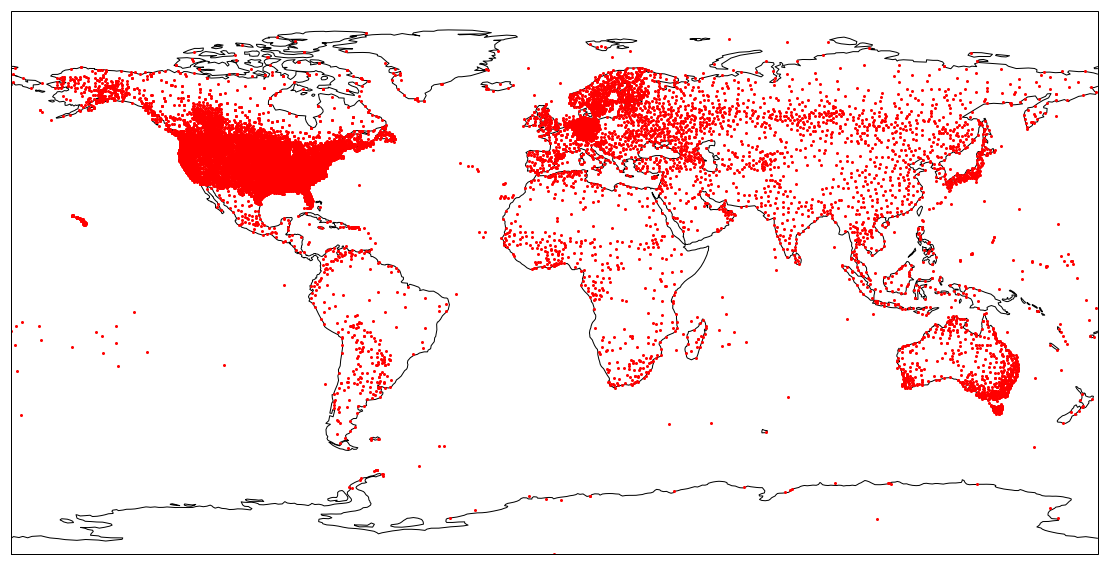

In [21]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keep], lat[keep], 'or', marker='o', markerfacecolor='r', markersize=2)


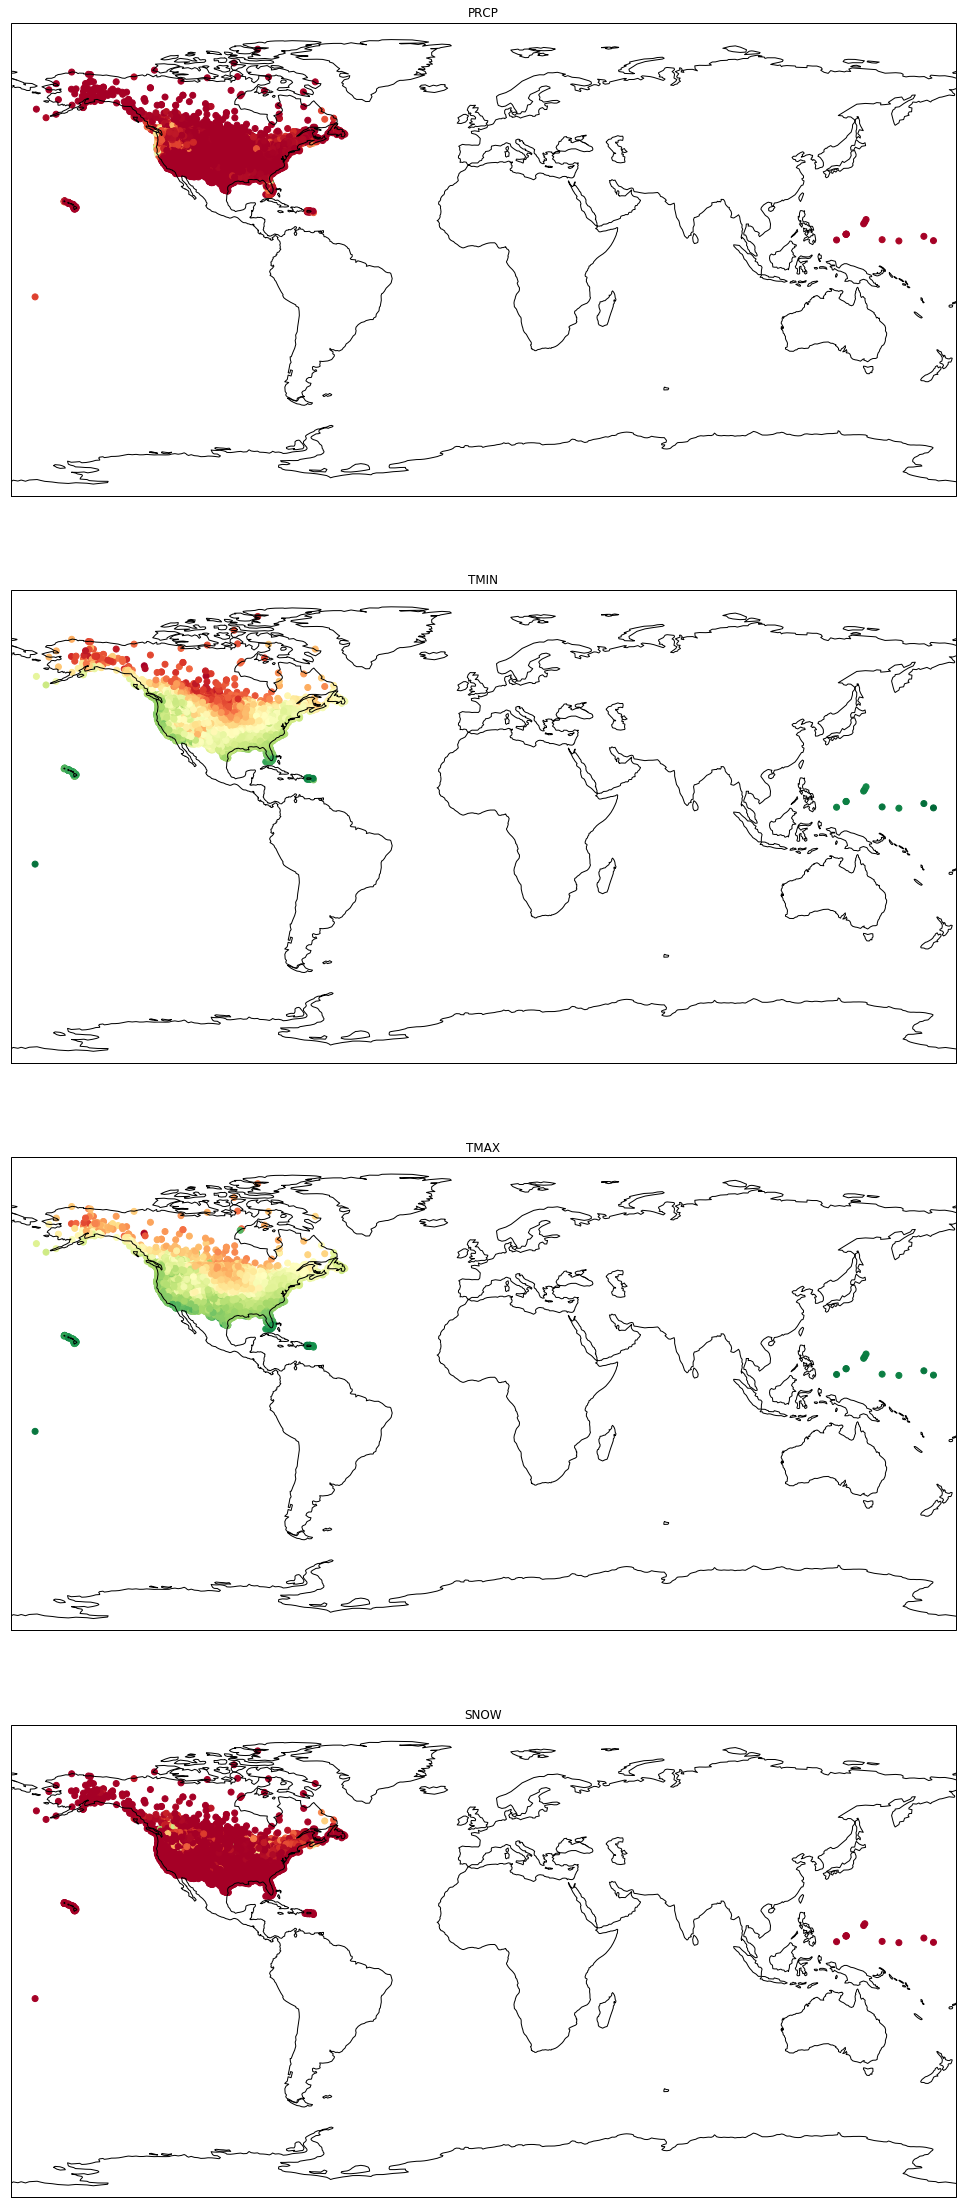

In [15]:
import cartopy.crs as ccrs

size = 40
fig = plt.figure(figsize=(2*size, 1*size))
for i in range(len(feature_names)):
    ax = fig.add_subplot(4, 1, i+1, projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.scatter(lon[keep], lat[keep], s=None, c=data[:,0,i], cmap=plt.get_cmap('RdYlGn'))
    ax.set_title(feature_names[i])

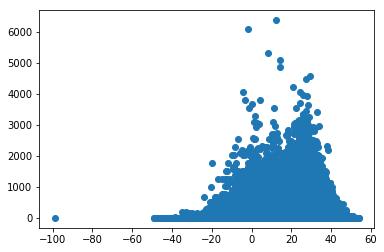

In [16]:
plt.scatter(data[:,:,2], data[:,:,0])

In [ ]:
plt.scatter(data[:,:,2], data[:,:,1])

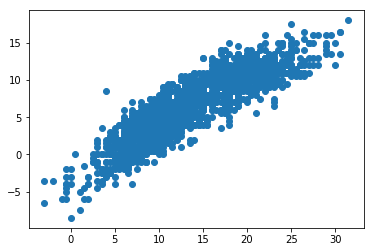

In [25]:
plt.scatter(data[9,:,2], data[9,:,1])

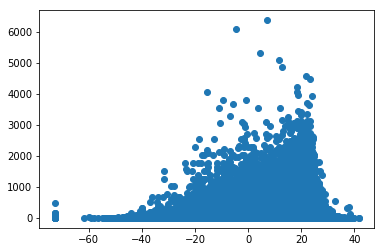

In [17]:
plt.scatter(data[:,:,1], data[:,:,0])

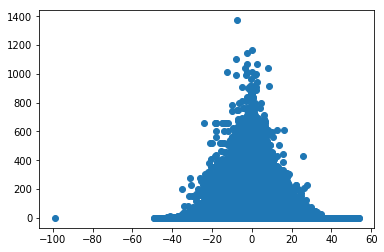

In [17]:
plt.scatter(data[:,:,2], data[:,:,3])

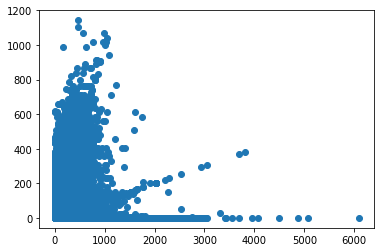

In [212]:
plt.scatter(data[:,:,0], data[:,:,3])

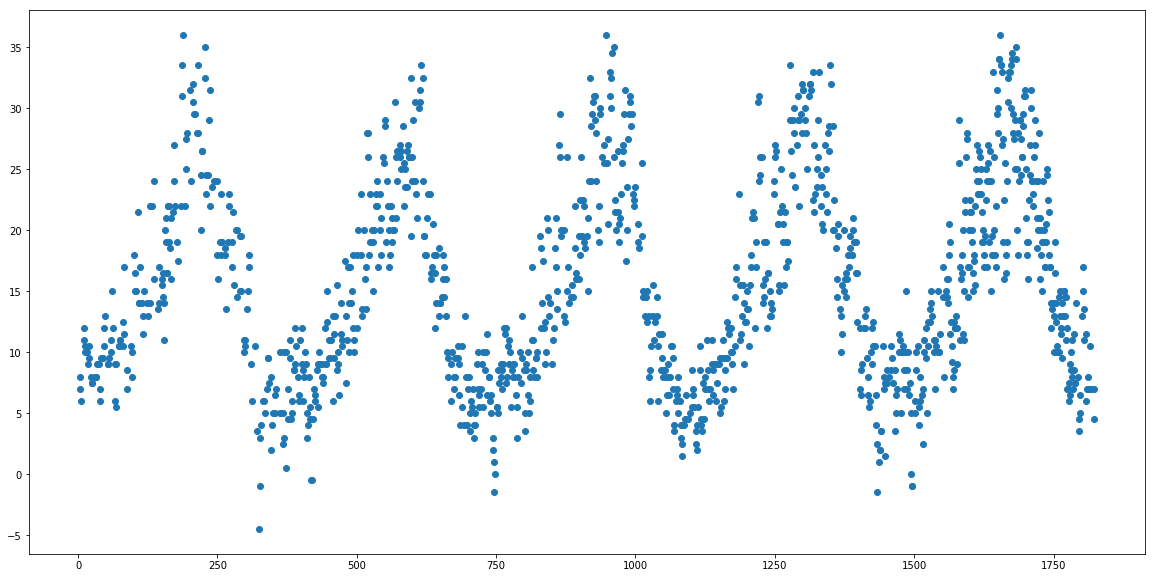

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(data[3,:,2], 'o')

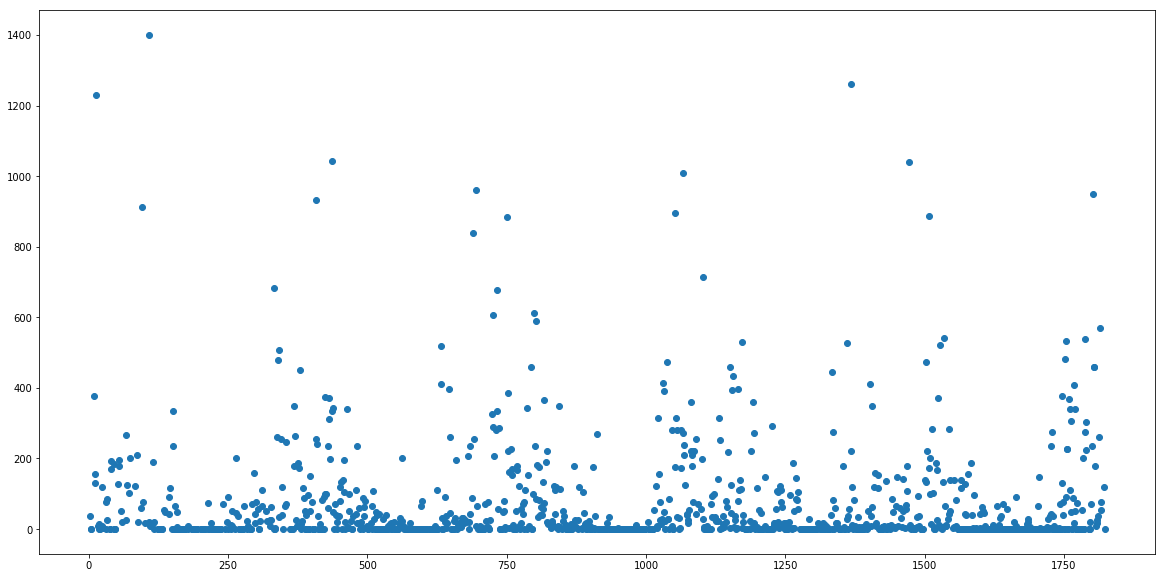

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(data[3,:,0], 'o')

In [131]:
from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph
class sphereGraph(NNGraph):
    def __init__(self, phi, theta, neighbors, rad=True, **kwargs):
        if not rad:
            theta, phi = np.deg2rad(theta), np.deg2rad(phi)
        theta -= np.pi/2
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        self.coords = np.vstack([x, y, z]).T
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])*0.5}
        super(sphereGraph, self).__init__(self.coords, k=neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [150]:
g = sphereGraph(lon[keep], lat[keep], 100, rad=False)

2019-05-06 15:57:19,058:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


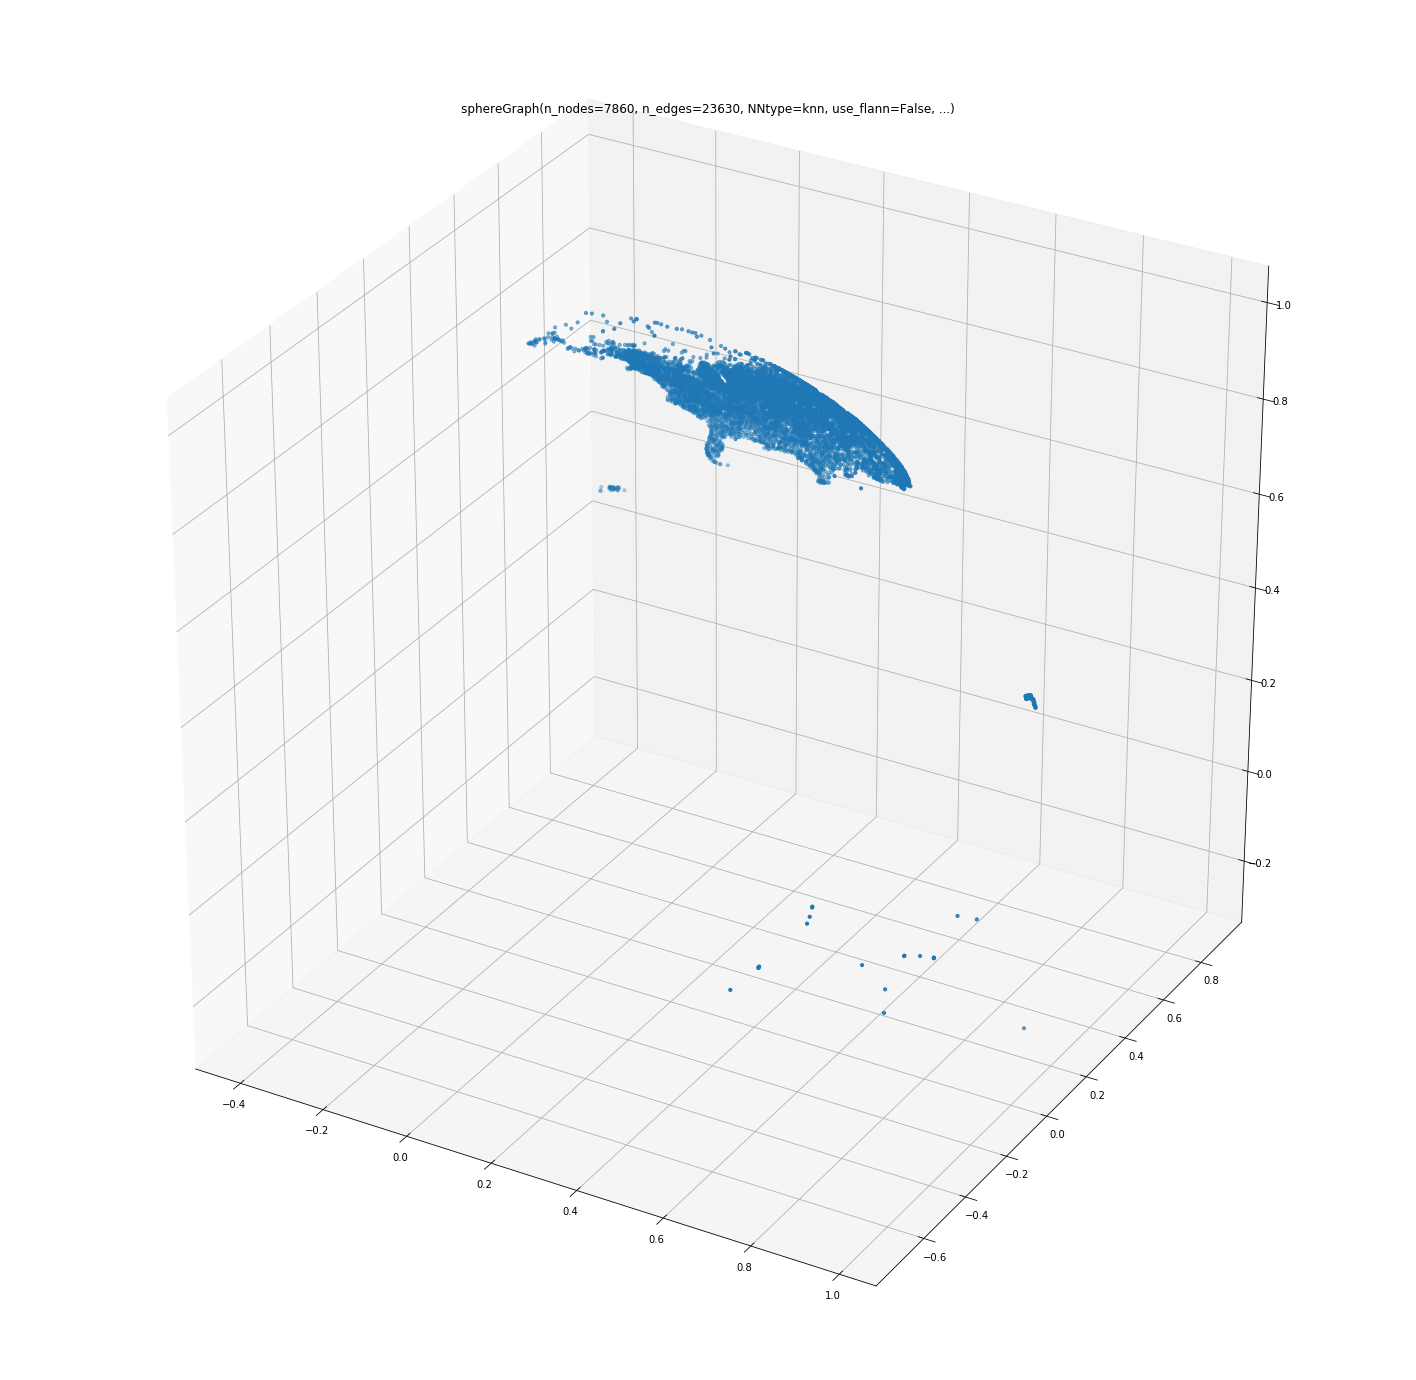

In [133]:
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
g.plot(vertex_size=10, edges=False, ax=axes)

2019-05-06 16:02:59,857:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the partial eigendecomposition of a large matrix (7860 x 7860) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


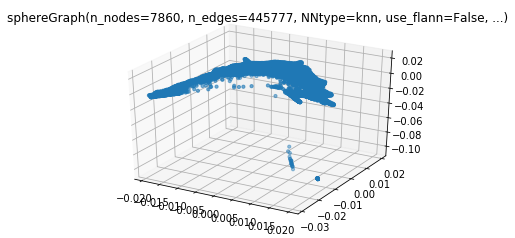

In [152]:
#g.compute_laplacian("normalized")
#g.compute_fourier_basis(recompute=True, n_eigenvectors=1000)
g.set_coordinates(g.U[:,1:4])
g.plot(vertex_size=10)

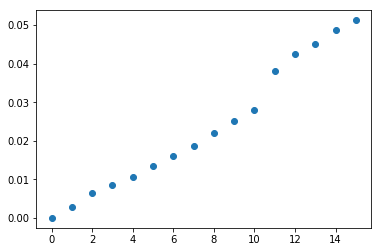

In [153]:
plt.plot(g.e[:16], 'o')

In [147]:
g_full = sphereGraph(lon, lat, 5000, rad=False)

2019-05-06 14:29:59,431:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


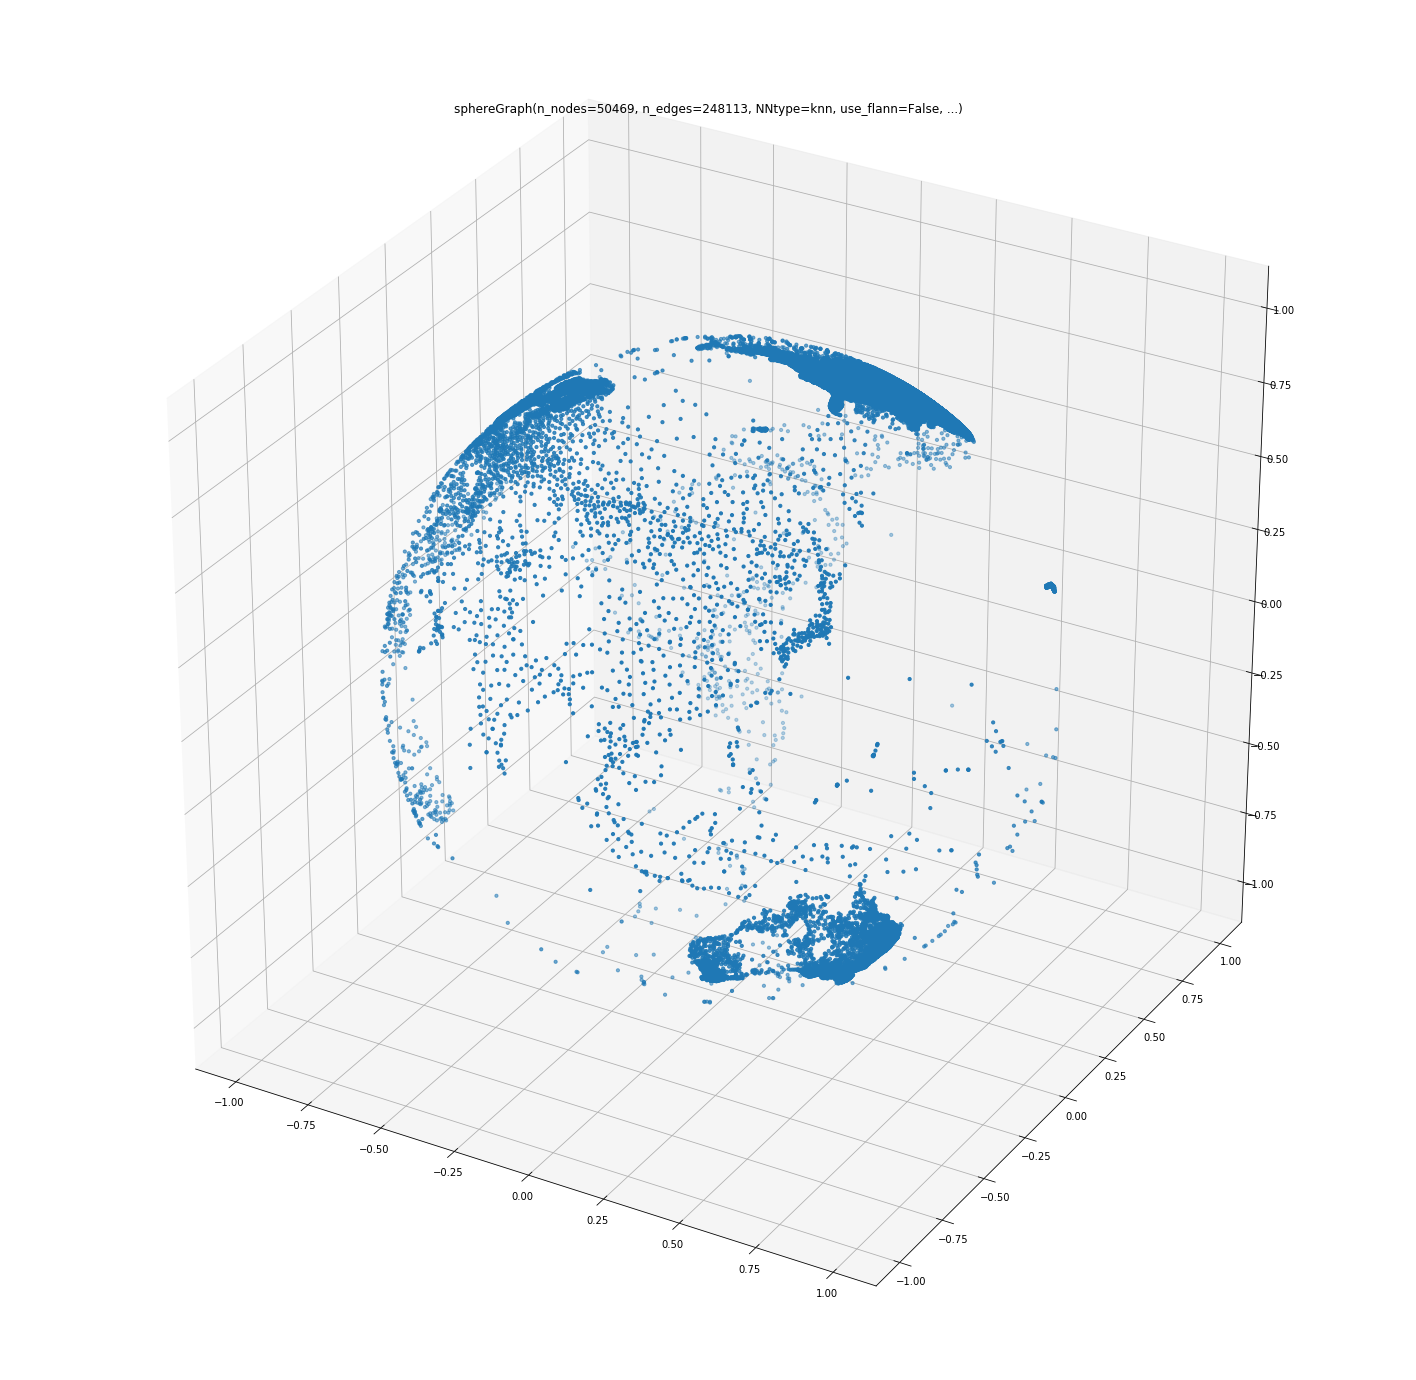

In [139]:
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
g_full.plot(vertex_size=10, edges=False, ax=axes)

2019-05-06 14:31:18,625:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the partial eigendecomposition of a large matrix (50469 x 50469) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


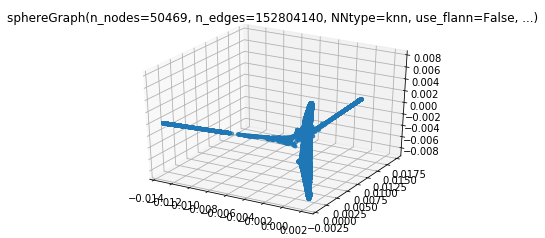

In [148]:
g_full.compute_laplacian("normalized")
g_full.compute_fourier_basis(recompute=True, n_eigenvectors=500)
g_full.set_coordinates(g_full.U[:,1:4])
g_full.plot(vertex_size=10)

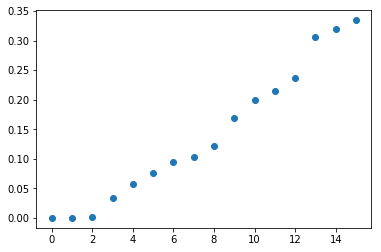

In [149]:
plt.plot(g_full.e[:16], 'o')

## inference train

In [252]:
import tensorflow as tf
params = {'L': [g.L.astype(np.float32)]*4,
          'p': [1,1,1,1],
          'F': [10, 20, 50, 1],
          'K': [5]*4,
          'batch_norm': [True]*4}
params['dir_name'] = 'GHCN_essai'
params['num_feat_in'] = 3
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 50  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(5e-1, step, decay_steps=5, decay_rate=1)
params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
n_evaluations = 200
params['eval_frequency'] = int(params['num_epochs'] * n_days / params['batch_size'] / n_evaluations)
params['M'] = []
params['regression']=True
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 7860
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 7860 * 20 / 1 = 157200
    weights: F_0 * F_1 * K_1 = 3 * 20 * 5 = 300
    biases: F_1 = 20
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 7860 * 50 / 1 = 393000
    weights: F_1 * F_2 * K_2 = 20 * 50 * 5 = 5000
    biases: F_2 = 50
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 7860 * 100 / 1 = 786000
    weights: F_2 * F_3 * K_3 = 50 * 100 * 5 = 25000
    biases: F_3 = 100
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 7860 * 1 / 1 = 7860
    weights: F_3 * F_4 * K_4 = 100 * 1 * 5 = 500
    batch normalization
  Statistical layer: mean
    representation: 1 * 1 = 1


In [221]:
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset

In [236]:
dataset[:,:,3].shape
np.isnan(dataset[:,:,3]).any(axis=0).shape


(1826,)

In [33]:
## temp max from temp min

dataset = data.transpose((1, 0, 2))
# keepToo = ~np.isnan(dataset[:,:,3]).any(axis=0)
# dataset = dataset[:,keepToo,:]
# print(dataset.shape)
ratio = 0.8
n_days = dataset.shape[0]
limit= int(ratio*n_days)

x_train = dataset[:limit,:,1]
labels_train = dataset[:limit,:,2]
x_val = dataset[limit:,:,1]
labels_val = dataset[limit:,:,2]


training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [ ]:
## precipitation from temp
dataset = data.transpose((1, 0, 2))

ratio = 0.8
n_days = dataset.shape[0]
limit= int(ratio*n_days)

x_train = dataset[:limit,:,1:3]
labels_train = dataset[:limit,:,0]
x_val = dataset[limit:,:,1:3]
labels_val = dataset[limit:,:,0]


training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [43]:
dataset.shape

(1826, 7860, 4)

In [44]:
np.vstack([np.roll(dataset, i, axis=0) for i in range(6)])

(10956, 7860, 4)

In [77]:
## temp future
dataset = data.transpose((1, 0, 2))[:,:,1:3]

dataset_x = np.vstack([np.roll(dataset, -i, axis=0) for i in range(6)])
dataset_x = dataset_x.reshape(6, n_days, n_stations, 2).transpose((1,2,3,0))

x_train = dataset_x[:n_days-7,:,0,:]
labels_train = dataset[7:,:,0]
x_val = dataset_x[:n_days-7,:,1,:]
labels_val = dataset[7:,:,1]


# training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [253]:
model.fit(training, validation)

InvalidArgumentError: Cannot use GPU when output.shape[1] * nnz(a) > 2^31
	 [[Node: conv4/filter/SparseTensorDenseMatMul/SparseTensorDenseMatMul = SparseTensorDenseMatMul[T=DT_FLOAT, Tindices=DT_INT64, adjoint_a=false, adjoint_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv4/filter/SparseReorder/_27, conv4/filter/SparseReorder/_29, conv4/filter/SparseTensor_1/dense_shape/_17, conv4/filter/Reshape)]]
	 [[Node: loss/add/_41 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1165_loss/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv4/filter/SparseTensorDenseMatMul/SparseTensorDenseMatMul', defined at:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-252-f8c3a008726c>", line 23, in <module>
    model = models.cgcnn(**params)
  File "/mnt/scratch/students/gusset/DeepSphere/deepsphere/models.py", line 702, in __init__
    self.build_graph(M_0, num_feat_in, tf_dataset, regression)
  File "/mnt/scratch/students/gusset/DeepSphere/deepsphere/models.py", line 414, in build_graph
    op_logits, self.op_descriptor = self.inference(self.ph_data, self.ph_training)
  File "/mnt/scratch/students/gusset/DeepSphere/deepsphere/models.py", line 445, in inference
    logits, descriptors = self._inference(data, training)
  File "/mnt/scratch/students/gusset/DeepSphere/deepsphere/models.py", line 871, in _inference
    x = self.filter(x, self.L[i], self.F[i], self.K[i], training)
  File "/mnt/scratch/students/gusset/DeepSphere/deepsphere/models.py", line 726, in chebyshev5
    x1 = tf.sparse_tensor_dense_matmul(L, x0)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/ops/sparse_ops.py", line 1822, in sparse_tensor_dense_matmul
    adjoint_b=adjoint_b)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/ops/gen_sparse_ops.py", line 2788, in sparse_tensor_dense_mat_mul
    name=name)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot use GPU when output.shape[1] * nnz(a) > 2^31
	 [[Node: conv4/filter/SparseTensorDenseMatMul/SparseTensorDenseMatMul = SparseTensorDenseMatMul[T=DT_FLOAT, Tindices=DT_INT64, adjoint_a=false, adjoint_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv4/filter/SparseReorder/_27, conv4/filter/SparseReorder/_29, conv4/filter/SparseTensor_1/dense_shape/_17, conv4/filter/Reshape)]]
	 [[Node: loss/add/_41 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1165_loss/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## regression problem